# Vanilla 3D U-Net

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install segmentation-models-3D

In [ ]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

In [ ]:
# Import libraries
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_3D as sm
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import Callback

In [ ]:
train_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_train_original2.npy')
train_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_train_mask1.npy')
validation_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_validation_original1.npy')
validation_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_validation_mask1.npy')
#test_original_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_test_original9.npy')
#test_mask_3D = np.load('/content/drive/MyDrive/3DPart/3D/3Dnpy/3D_test_mask9.npy')

In [ ]:
print("Shape of the data:", train_original_3D.shape)
print("Shape of the data:", validation_mask_3D.shape)

Shape of the data: (112, 128, 128, 64, 3)
Shape of the data: (16, 128, 128, 64, 2)


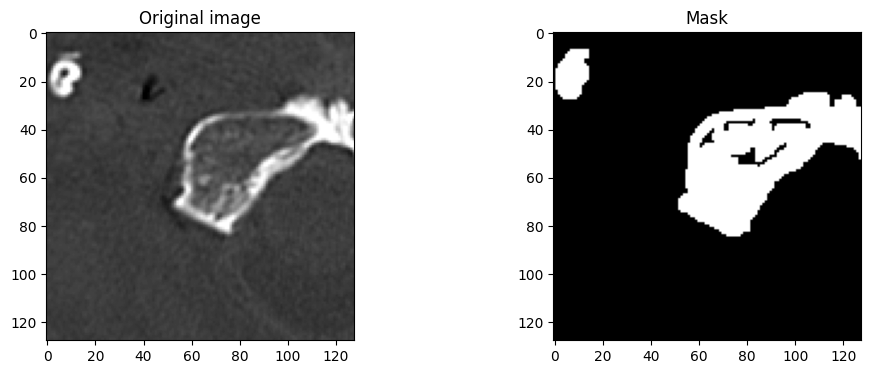

In [ ]:
# Check the patches
# Change the patch and slice
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original_3D[105,:,:,25,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask_3D[105,:,:,25,0], cmap='gray')
axes[1].set_title('Mask')

plt.show()

In [ ]:
# Normalization of the data
scaler = MinMaxScaler()

train_original_3D = scaler.fit_transform(train_original_3D.reshape(-1, train_original_3D.shape[-1])).reshape(train_original_3D.shape)
validation_original_3D = scaler.fit_transform(validation_original_3D.reshape(-1, validation_original_3D.shape[-1])).reshape(validation_original_3D.shape)
#test_original_3D = scaler.fit_transform(test_original_3D.reshape(-1, test_original_3D.shape[-1])).reshape(test_original_3D.shape)

In [ ]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss

In [ ]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
kernel_initializer =  'he_uniform'

def vanilla_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Encoder
    c1 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    # Decoder
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), kernel_initializer=kernel_initializer, padding='same')(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #model.summary()

    return model

In [ ]:
model = vanilla_unet_model(IMG_HEIGHT=128,
                           IMG_WIDTH=128,
                           IMG_DEPTH=64,
                           IMG_CHANNELS=1,
                           num_classes=1)

In [ ]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d_152 (Conv3D)            (None, 128, 128, 64  448         ['input_9[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization_144 (Batch  (None, 128, 128, 64  64         ['conv3d_152[0][0]']             
 Normalization)                 , 16)                                                       

In [ ]:
# Save the output of every epoch
class SavePredictionsCallback(Callback):
    def __init__(self, validation_data, save_dir):
        super(SavePredictionsCallback, self).__init__()
        self.validation_data = validation_data
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        predicted_masks = self.model.predict(self.validation_data[0])

        for i in range(len(self.validation_data[0])):
            self.save_or_visualize_results(
                self.validation_data[0][i],
                self.validation_data[1][i],
                predicted_masks[i],
                epoch,
                i
            )

    def save_or_visualize_results(self, input_image, true_mask, predicted_mask, epoch, sample_idx):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_image[:,:,43], cmap='gray')
        axes[0].set_title('Input Image')

        axes[1].imshow(true_mask[:,:,43], cmap='gray')
        axes[1].set_title('True Mask')

        axes[2].imshow(predicted_mask[:,:,43], cmap='gray')
        axes[2].set_title('Predicted Mask')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch}_sample_{sample_idx}.png'))
        plt.close()

In [ ]:
save_dir = '/content/drive/MyDrive/3DPart/3D/Model_training_prediction/vanilla3D'
os.makedirs(save_dir, exist_ok=True)

save_predictions_callback = SavePredictionsCallback(validation_data=(validation_original_3D[:,:,:,:,0], validation_mask_3D[:,:,:,:,0]), save_dir=save_dir)

In [ ]:
history = model.fit(train_original_3D[:,:,:,:,0],
          train_mask_3D[:,:,:,:,0],
          batch_size = 16,
          epochs = 130,
          verbose = 1,
          validation_data=(validation_original_3D[:,:,:,:,0], validation_mask_3D[:,:,:,:,0]))
          #callbacks=[save_predictions_callback])

Epoch 1/130
28/28 [==============================] - 9s 233ms/step - loss: 0.6787 - iou_score: 0.3967 - f1-score: 0.5428 - val_loss: 0.7223 - val_iou_score: 0.2168 - val_f1-score: 0.3541
Epoch 2/130
28/28 [==============================] - 6s 203ms/step - loss: 0.6210 - iou_score: 0.5667 - f1-score: 0.7059 - val_loss: 0.7329 - val_iou_score: 0.1944 - val_f1-score: 0.3235
Epoch 3/130
28/28 [==============================] - 6s 203ms/step - loss: 0.5954 - iou_score: 0.6169 - f1-score: 0.7539 - val_loss: 0.6494 - val_iou_score: 0.5470 - val_f1-score: 0.7070
Epoch 4/130
28/28 [==============================] - 6s 203ms/step - loss: 0.5473 - iou_score: 0.6712 - f1-score: 0.7896 - val_loss: 0.7015 - val_iou_score: 0.5399 - val_f1-score: 0.6831
Epoch 5/130
28/28 [==============================] - 6s 202ms/step - loss: 0.5119 - iou_score: 0.7012 - f1-score: 0.8139 - val_loss: 0.7082 - val_iou_score: 0.3155 - val_f1-score: 0.4788
Epoch 6/130
28/28 [==============================] - 6s 203ms/ste

In [ ]:
# Plot loss curves
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim(0, 0.8)
plt.yticks(np.arange(0, 0.9, 0.1))
plt.title('Model Loss (Vanilla Unet-3D, cv1)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/3DPart/3D/3DUNetModel/vanilla_3D_cv1.h5')